# либы

In [2]:
# Standard python libraries
import os
import re
import time
from datetime import datetime

import pymssql
import psycopg2

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import f1_score,confusion_matrix,precision_recall_curve
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import log_loss,roc_curve,auc,roc_auc_score,average_precision_score,accuracy_score, f1_score

import itertools
from collections import Counter, OrderedDict
import autowoe
import xgboost as xgb
import lightgbm as lgb

from autowoe import ReportDeco, AutoWoE
from lightautoml.report import ReportDeco
import lightautoml
import category_encoders

from tqdm import tqdm
from copy import deepcopy

#Imports from LightAutoML package
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

# Additional libs for feature creation from raw data
# The V3 lib takes time to init (the database is massive). Tip: Put it into the init of your app.
from names_dataset import NameDataset
names = NameDataset()
# check phone-numbers
import phonenumbers

In [46]:
# будем отображать графики прямо в jupyter'e
%matplotlib inline

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

# Сброс ограничений на количество выводимых рядов
pd.set_option('display.max_rows', None)

# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

# для матомо

In [47]:
# Фунция для обработки HTTP запроса
import requests
from requests.exceptions import HTTPError

def HTTP_request(url: str) -> dict:
    try:
        response = requests.get(url)
        # если ответ успешен, исключения задействованы не будут
        response.raise_for_status()
    except HTTPError as http_err:
        #print(f'HTTP error occurred: {http_err}')
        return None
    except Exception as err:
        #print(f'Other error occurred: {err}')
        return None
    else:
        return response.json()

In [1330]:
# Функция принимает на вход matomo_id и время оставления лида 
# и возвращает на выходе агрегированные метрики по лиду с данными  matomo_id

def get_matomo_features (visitorId: str, datetime_leadcreated: datetime, token: str, 
                         last_features: list, sum_features: list) -> dict:
    """
    params: 
    visitor_id: visitor_id который привязался к интересующему lead_id
    datetime_leadcreated: дата создания лида
    token: token для доступа к данным через HTTPS запрос
    last_features: фичи, которые будут возвращены из последнего визита до оставления заявки
    sum_features: фичи, которые возвращаются как агрегаты по всем посещениям до оставления заявки. Например суммарное время на странице
    """
    if visitorId is None:
        return None
    
    # задаем глобальные переменные
    name = 'lastVisits'
    # формируем json с данными из API Матомо
    last_visit = None # инициализируем переменную для хранения последнего визита до оставления заявки
    url = 'https://matomo.synergy.ru/?module=API&method=Live.getVisitorProfile&idSite=1&format=JSON&token_auth=' + \
            token + \
            '&visitorId=' + \
            visitorId
    # создаем результирующий словарь
    res_dict = {}
    # инициализируем словарь изначально нулями для тех фичей, которые считются как агрегаты по посещениям
    for k in sum_features:
        res_dict[k] = 0
    # получаем данные из Матомо в виде словаря, если словарь пустой, то None 
    matomo_stat = HTTP_request(url)
    # флаг того, что найдено хотя бы одно посещение для которого время посещения меньше, чем время когда была оставлена заявка
    flag_find_last_visit = False
    if not matomo_stat:
        return None
    else:
        for visits in range(len(matomo_stat.get(name, None))):
                # для каждого визита фиксируем время обработки
                current_visit = matomo_stat.get(name, None)[visits]
                serverDate = current_visit.get('serverDate', None)
                serverTimePrettyFirstAction = current_visit.get('serverTimePrettyFirstAction', None)
                try:
                    date_string = serverDate + ' ' + serverTimePrettyFirstAction
                    date_time_visits = datetime.fromisoformat(date_string)
                except Exception as err:
                    date_time_visits = None
                # если date_time_visits не None, то нужно сравнить это время с временем создания лида.
                # и если полученное время посещения меньше чем время когда был создан лид, то тогда обрабатываем этот визит
                if date_time_visits and date_time_visits < datetime_leadcreated:
                    #print('date_time_visits = ', date_time_visits, 'datetime_leadcreated = ', datetime_leadcreated)
                    # флаг поиска ставим в True если нашли хоты бы один визит раньше чем время лида 
                    flag_find_last_visit = True
                    # если найден первый визит раньше времени оставления лида
                    if not last_visit:
                        last_visit = date_time_visits
                        for k in last_features:
                            res_dict[k] = current_visit.get(k, None)
                        for k in sum_features:
                            # если не получается приплюсовать значение фичи, то идем дальше по списку фичей
                            try:
                                res_dict[k]+=int(current_visit.get(k, None))
                            except Exception as err:
                                continue
                    # если найден еще один визит раньше времени оставления лида
                    else:
                        # если время этого визита больше чем время последнего найденного визита
                        # знчит мы обновляем все данные для фичей, которые берутся только для пос визита
                        # и плюуем значения для суммирующихся метрик
                        if date_time_visits > last_visit:
                            #print('date_time_visits = ', date_time_visits, 'last_visit = ', last_visit)
                            last_visit = date_time_visits
                            for k in last_features:
                                res_dict[k] = current_visit.get(k, None)
                            for k in sum_features:
                                # если не получается приплюсовать значение фичи, то идем дальше по списку фичей
                                try:
                                    res_dict[k]+=int(current_visit.get(k, None))
                                except Exception as err:
                                    continue                            
                        # если время визита меньше чем время последнего найденного визита (но все еще меньше чем время лида)
                        else:
                            for k in sum_features:
                                # если не получается приплюсовать значение фичи, то идем дальше по списку фичей
                                try:
                                    res_dict[k]+=int(current_visit.get(k, None))
                                except Exception as err:
                                    continue
    if flag_find_last_visit:
        return res_dict
    else:
        return None

In [1331]:
def matomo_stat(leads: list, visits: list, dates: list):
    res = pd.DataFrame()
    for l, v, d in zip(leads, visits, dates):
        d = get_matomo_features(v, d, token, last_visit_features, sum_features)
        if d and not res.empty:
            d  = pd.DataFrame([d])
            d['id_lead'] = l
            res = pd.concat([res, d], ignore_index=True)
        elif d and res.empty:
            d  = pd.DataFrame([d])
            d['id_lead'] = l
            res = d.copy()
    return res

# Функции для проверки данных

In [48]:
#1 создание из поля с именем фичи есть ли такое имя или фаимилия в базе популярных имен
def title_check(st):
    if st is None or st == '':
        return False
    else:
        # проверяем через доп.библиоетку о том что такое имя или фамилия существуют
        for s in st.strip().split():
            if any(names.search(s).values()):
                return True
        return False

#2 уникальное количество букв в имени
def get_alpha_unique_numbers(st):
    if st is None or st=='':
        return 0
    else:
        return len(set([x for x in st if x.isalpha()]))/len(st)

#3 доля  заглавных букв в имени
def get_alpha_UPPER_numbers(st):
    if st is None or st=='':
        return 0
    else:
        return sum(map(str.isupper,st))/len(st)
    
#4 длина имени (все символы удаляя пробелы)
def get_title_length(st):
    if st is None or st=='':
        return 0
    else:
        s = st.replace(' ', '')
        return len(s)

#5 количество слов в имени
def get_word_count(st):
    if st is None or st=='':
        return 0
    else:
        return len(st.strip().split(" "))

#6 есть ли в имени символы на кириллице
def has_cyrillic_letter(st):
    if st is None or st=='':
        return False
    else:
        return bool(re.search('[а-яА-Я]', st))

#7 есть ли в имени символы англ алфаивта
def has_engl_letter(st):
    if st is None or st=='':
        return False
    else:
        return bool(re.search('[a-zA-Z]', st))
    
#8 создание из поля с телефоном фичи есть ли такой номер телефона через библиотеку
def phone_check(st):
    if st is None or st=='':
        return False
    else:
        s = ''.join([str(elem) for elem in st if elem.isdigit()])
        if len(s)==11 and s[0]=='8':
            s = '+7' + s[1:]
        else:
            s = '+' + s[:]
        try:
            my_number = phonenumbers.parse(s)
            return phonenumbers.is_valid_number(my_number)
        except:
            return False
        
#9 уникальное количество цифр в номере/или любом другом объекте
def get_digit_unique_numbers(st):
    if st is None or st=='':
        return 0
    else:
        return len(set([x for x in st if x.isdigit()]))/len(st)

#10 длина только цифр в номере
def get_digit_length(st):
    if st is None or st=='':
        return 0
    else:
        s = ''.join([str(elem) for elem in st if elem.isdigit()])
        return len(s)

In [49]:
def to_datetime(date):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python datetime object
    """
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    return datetime.utcfromtimestamp(timestamp)

# ФУНКЦИИ ДЛЯ ПОСТОБРАБОТКИ

In [50]:
def best_features(train_data, test_data, features_importance_list):
    

    features = []
    len_of_features = []
    model_quality = []
    
    task = Task('binary', metric = roc_auc_score)
    roles = {'target': 'SPAM_flag'}
    
    
    for i in features_importance_list: 
        features.append(i)
        len_of_features.append(len(features))

        automl = TabularAutoML(task = task, 
                           timeout = 600, # 1800 seconds = 30 minutes
                           cpu_limit = -1, # Optimal for Kaggle kernels
                           general_params = {'use_algos': [['catboost','lgb', 'lgb_tuned']]})
    
    
        model = automl.fit_predict(train_data[features + ['SPAM_flag']], roles = roles)
        valid_pred = automl.predict(test_data[features + ['SPAM_flag']])
        
        model_quality.append(roc_auc_score(test_data['SPAM_flag'].values,  valid_pred.data[:,0]))
        
        print('VAL ROC_AUC: {}'.format(roc_auc_score(test_data['SPAM_flag'].values,  valid_pred.data[:,0])))
        
    plt.plot(len_of_features, model_quality)
    plt.show()

In [51]:
def best_ridge(test, ridge, step):
    
    i = ridge
    
    ridge_list = []
    model_quality = []
    
    while i < 1:
        
        test['spam_proba_'+str(i)] = test['spam_proba'].apply(lambda x: 1 if x>i else 0)
        roc_auc = roc_auc_score(test['SPAM_flag'].values,  test['spam_proba_'+str(i)].values)
        
        ridge_list.append(i)
        model_quality.append(roc_auc)
        
        i+=step
        #print(i,roc_auc)
    plt.plot(ridge_list, model_quality)
    plt.show()

In [52]:
def metrics_bb(df, need_department):
    
    result = pd.DataFrame()
    i = 0.1
    while i < 1:
        mid_res = pd.DataFrame()
        df['spam_proba_'+str(i)] = df['spam_proba'].apply(lambda x: 1 if x > i else 0)
        for depart in need_department:
            res = pd.DataFrame()
            ddf = df[df['resp_depart_lv2'] == depart]
            
            y_pred = ddf['spam_proba_'+str(i)].values
            y_real = ddf['SPAM_flag'].values
            
            metr = list(confusion_matrix(y_real, y_pred).ravel())
            
            res['TN'] = pd.Series(metr[0])
            res['FP'] = pd.Series(metr[1])
            res['FN'] = pd.Series(metr[2])
            res['TP'] = pd.Series(metr[3])
            
            res['precision'] = res['TP']/(res['TP'] + res['FP'])
            res['recall'] = res['TP']/(res['TP']+res['FN'])
            res['F1'] = 2*res['precision']*res['recall']/(res['precision']+res['recall'])
            
            res['probability'] =  str(i)
            res['resp_depart_lv2'] = depart
            
            mid_res = pd.concat([mid_res, res], axis = 0)
        i+=0.1
        result = pd.concat([result, mid_res], axis = 0)
    return(result)
        

In [53]:
def metrics_wb(df, need_department):
    
    result = pd.DataFrame()
    for depart in need_department:
        res = pd.DataFrame()
        ddf = df[df['resp_depart_lv2'] == depart]
        
        y_pred = ddf['SPAM_flag_wb']
        y_real = ddf['SPAM_flag']
        
        metr = list(confusion_matrix(y_pred, y_real).ravel())
        
        res['TN'] = pd.Series(metr[0])
        res['FP'] = pd.Series(metr[1])
        res['FN'] = pd.Series(metr[2])
        res['TP'] = pd.Series(metr[3])
        res['resp_depart_lv2'] = depart
        
        result = pd.concat([result, res], axis = 0)
    return(result)

# ###################################
# данные
# ###################################

### matomo

In [436]:
%%time
# читаем данные из базы в датафрейм
data_matomo = pd.DataFrame()

with pymssql.connect(host='MSK1-ADB01', database='Analytic') as conn:
    data_matomo = pd.read_sql_query("SELECT * FROM dbo.big_leads_matomo with (nolock)", conn)

CPU times: total: 2.03 s
Wall time: 4.02 s


In [437]:
%%time
# читаем данные из базы в датафрейм
data_matomo_2 = pd.DataFrame()

with pymssql.connect(host='MSK1-ADB01', database='Analytic') as conn:
    data_matomo = pd.read_sql_query("SELECT * FROM dbo.test_leads_matomo with (nolock)", conn)

CPU times: total: 734 ms
Wall time: 1.52 s


In [438]:
%%time
data_matomo_full = pd.concat([data_matomo, data_matomo_2], sort = False, axis = 0)

CPU times: total: 15.6 ms
Wall time: 25.6 ms


### lead

In [6]:
%%time
# читаем данные из базы в датафрейм
data_p1 = pd.DataFrame()

with pymssql.connect(host='MSK1-ADB01', database='Analytic') as conn:
    data_p1 = pd.read_sql_query("SELECT * FROM dbo.RAF_spam_model_test_p1 with (nolock)", conn)

CPU times: total: 14.8 s
Wall time: 21.2 s


In [387]:
data_p1['datetime_leadcreated'].min(), data_p1['datetime_leadcreated'].max()

(Timestamp('2022-03-01 00:00:57'), Timestamp('2022-10-05 23:59:43'))

In [7]:
%%time
# читаем данные из базы в датафрейм
data_p2 = pd.DataFrame()

with pymssql.connect(host='MSK1-ADB01', database='Analytic', charset="cp1251") as conn:
    data_p2 = pd.read_sql_query("SELECT * FROM dbo.RAF_spam_model_test_p2 with (nolock)", conn)

CPU times: total: 5.7 s
Wall time: 6.03 s


In [389]:
data_full = data_p1.merge(data_p2, left_on = 'id_lead', right_on = 'id_lead')

In [390]:
data_full.shape

(860271, 34)

### full data

In [71]:
# %%time
# data_full = data_lead_full.merge(data_matomo_full, on = 'id_lead', how = 'left')

In [391]:
#только нужные статусы
data_full =  data_full[data_full['lead_status'].isin(['Сконвертирован', 'Перезвон', 'Перспектива', 'Спам'])]
data_full.shape

(278023, 34)

# ###################################
# применение функций к данным
# ###################################

In [392]:
%%time
# создание из поля с именем (title) фичи есть ли такое имя или фаимилия в базе популярных имен
data_full['title_check'] = data_full['title'].apply(title_check)
data_full['title_alpha_unique_share'] = data_full['title'].apply(get_alpha_unique_numbers)
data_full['title_alpha_upper_share'] = data_full['title'].apply(get_alpha_UPPER_numbers)
data_full['title_length'] = data_full['title'].apply(get_title_length)
data_full['title_word_count'] = data_full['title'].apply(get_word_count)
data_full['title_has_cyrillic_letter'] = data_full['title'].apply(has_cyrillic_letter)
data_full['title_has_engl_letter'] = data_full['title'].apply(has_engl_letter)
data_full['phone_check'] = data_full['phone'].apply(phone_check)
data_full['PHONE_digit_unique_share'] = data_full['phone'].apply(get_digit_unique_numbers)
data_full['PHONE_length'] = data_full['phone'].apply(get_digit_length)
data_full['datetime_leadcreated'] = pd.to_datetime(data_full['datetime_leadcreated'])

CPU times: total: 38.2 s
Wall time: 38.2 s


In [393]:
work_data = data_full

# ###################################
# выделяю рабочие данные 
# ###################################

In [279]:
need_department = \
(
    'Школа Бизнеса Синергия'
    ,'Synergy Business School Dubai '
    ,'Департамент регионального бизнеса'
    ,'Департамент международного бизнеса'
    ,'Коммерческий департамент'
    ,'Коммерческий департамент 2'
    ,'МАП'
)

In [132]:
%%time
#выделяю нужные департаменты

work_data = \
(
    data_full
    .query('resp_depart_lv2 in @need_department')
)

CPU times: total: 1.72 s
Wall time: 1.73 s


# ###################################
# Предобработка data
# ###################################

In [394]:
%%time
#заменяем таргет
work_data['SPAM_flag'] = \
(
    pd
    .Series(work_data['lead_status'] =='Спам')
    .map({False: 0, True: 1})
)

#кодируем проверку имени
work_data['title_check'] = \
(
    work_data
    .title_check
    .map({False: 0, True: 1})
)

#кодируем проверку имени кириллица
work_data['title_has_cyrillic_letter'] = \
(
    work_data
    .title_has_cyrillic_letter
    .map({False: 0, True: 1})
)

#кодируем проверку имени латиница
work_data['title_has_engl_letter'] = \
(
    work_data
    .title_has_engl_letter
    .map({False: 0, True: 1})
)

#кодируем проверку телефона
work_data['phone_check'] = \
(
    work_data
    .phone_check
    .map({False: 0, True: 1})
)

CPU times: total: 141 ms
Wall time: 140 ms


In [395]:
# features_type = \
# {
#     'day_of_week': 'cat'
#     ,'hour': 'cat'
#     ,'email_domain': 'cat'
#     ,'version_id': 'real'
#     ,'flag_analytics_id': 'real'
#     ,'flag_MERGE_LEAD': 'real'
#     ,'sourceCode': 'cat'
#     ,'flag_campaign': 'real'
#     ,'medium': 'cat'
#     ,'flag_term': 'real'
#     ,'flag_utm_content': 'real'
#     ,'flag_utm_keyword': 'real'
#     ,'flag_lead_form': 'real'
#     ,'Country_IP': 'cat' #matomo                  
#     ,'Region_IP': 'cat' #matomo 
#     ,'URL_domen': 'cat' 
#     ,'visitDuration': 'real' #matomo 
#     ,'searches': 'real'#matomo 
#     ,'actions': 'real'#matomo 
#     ,'interactions': 'real'#matomo 
#     ,'visitLocalHour': 'cat'#matomo 
#     ,'languageCode': 'cat'#matomo 
#     ,'deviceType': 'cat'#matomo 
#     ,'deviceBrand': 'cat'#matomo 
#     ,'operatingSystemName': 'cat'#matomo 
#     ,'browserFamily': 'cat'#matomo 
#     ,'continent': 'cat'#matomo 
#     ,'daysSinceLastVisit': 'real'#matomo 
#     ,'secondsSinceLastVisit': 'real'#matomo 
#     ,'title_check': 'real'
#     ,'title_alpha_unique_share': 'real'
#     ,'title_alpha_upper_share': 'real'
#     ,'title_length': 'real'
#     ,'title_word_count': 'real'
#     ,'title_has_cyrillic_letter': 'real'
#     ,'title_has_engl_letter': 'real'
#     ,'phone_check': 'real'
#     ,'PHONE_digit_unique_share': 'real'
#     ,'PHONE_length': 'real' 
#     ,'time_fst_act-lead': 'real'  #matomo-lend
# }

In [396]:
scale_features_ab = ['day_of_week',
                     'email_domain',
                     'sourceCode',
                     'medium',
                     'Country_IP',
                     'Region_IP',
                     'URL_domen',
                     'title_length',
                     'title_length',
                     'PHONE_length',
                     'hour'
                    ]

# TRAIN TEST SPLIT

In [397]:
train = work_data[work_data['datetime_leadcreated'] < '2022-08-01']
test = work_data[(work_data['datetime_leadcreated'] >= '2022-08-01') & ((work_data['datetime_leadcreated'] < '2022-11-01'))]

In [398]:
print (min(train['datetime_leadcreated']), max(train['datetime_leadcreated']))
#print (min(valid['datetime_leadcreated']), max(valid['datetime_leadcreated']))
print (min(test['datetime_leadcreated']), max(test['datetime_leadcreated']))

2022-03-01 00:02:59 2022-07-31 23:59:57
2022-08-01 00:04:20 2022-10-05 23:58:56


# ----------------------------- ----------------------------- -----------------------------
# ----------------------------- ----------------------------- ----------------------------- 

# target encoding

In [399]:
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

In [403]:
cat_features_ab = ['day_of_week',
 'email_domain',
 'sourceCode',
 'medium',
 'Country_IP',
 'Region_IP',
 'URL_domen',
 'title_length',
 'PHONE_length',
'hour']

In [404]:
tenc=ce.TargetEncoder() 

In [405]:
%%time
encoded_train = tenc.fit_transform(train[cat_features_ab], train['SPAM_flag'])

CPU times: total: 8.36 s
Wall time: 8.36 s


In [406]:
%%time
encoded_test = tenc.transform(test[cat_features_ab], test['SPAM_flag'])

CPU times: total: 469 ms
Wall time: 472 ms


In [407]:
train[cat_features_ab] = encoded_train
test[cat_features_ab] = encoded_test

# std scaler

In [408]:
scaler = StandardScaler()

In [409]:
%%time
#на трейне
scaled_train = scaler.fit_transform(train[scale_features_ab])

CPU times: total: 78.1 ms
Wall time: 75 ms


In [410]:
%%time 
#на тесте + аб тест
scaled_test = scaler.transform(test[scale_features_ab])
#scaled_ab = scaler.transform(work_data_ab[scale_features_ab])

CPU times: total: 15.6 ms
Wall time: 24 ms


In [411]:
train[scale_features_ab] = scaled_train
test[scale_features_ab] = scaled_test
#work_data_ab[scale_features_ab] = scaled_ab

#  ----------------------------- ----------------------------- -----------------------------
# ----------------------------- ----------------------------- -----------------------------

# ###################################
# LAMA MODEL
# ###################################

In [412]:
task = Task('binary', metric = roc_auc_score)
roles = {'target': 'SPAM_flag'}
automl = TabularAutoML(task = task, 
                       timeout = 600, # 1800 seconds = 30 minutes
                       cpu_limit = -1, # Optimal for Kaggle kernels
                       general_params = {'use_algos': [['catboost','lgb', 'lgb_tuned']]}
                      )

In [413]:
%%time
oof_pred = automl.fit_predict(train[top_15_features + ['SPAM_flag']], roles = roles)

CPU times: total: 1h 23min 17s
Wall time: 5min 32s


In [375]:
# %%time
# valid_pred = automl.predict(valid[features + ['SPAM_flag']])

In [324]:
%%time
test_pred = automl.predict(work_data_ab[top_15_features + ['SPAM_flag']])

CPU times: total: 1min 13s
Wall time: 6.49 s


In [385]:
train[top_15_features].head()

,phone_check,sourceCode,title_check,Region_IP,flag_campaign,PHONE_digit_unique_share,Country_IP,email_domain,title_length,title_alpha_upper_share,flag_MERGE_LEAD,hour,title_alpha_unique_share,title_has_cyrillic_letter,PHONE_length
1,NaN,-0.587506,NaN,-0.650305,1,0.333333,-0.404078,-0.468858,1.163771,0.058824,1,7,0.647059,NaN,0.729746
3,NaN,-0.769653,NaN,-0.693020,1,0.545455,-0.404078,-0.512746,-0.730190,0.200000,1,7,1.000000,NaN,0.122612
7,NaN,-0.814712,NaN,-0.561652,1,0.727273,-0.404078,-0.468858,-0.730190,0.200000,1,8,1.000000,NaN,0.122612
13,NaN,-0.769653,NaN,1.036134,1,0.666667,-0.597464,0.716575,1.353167,0.117647,1,8,0.705882,NaN,0.729746
15,NaN,-0.769653,NaN,-0.749150,1,0.636364,-0.404078,-0.366905,-0.919586,0.250000,1,8,0.750000,NaN,0.122612


# ###################################
# МЕТРИКИ
# ###################################

### 01.03.2022-31.07.2022 с предобработкой топ фичи

In [154]:
print('OOF ROC_AUC: {}'.format(roc_auc_score(train['SPAM_flag'].values, oof_pred.data[:, 0])))

print('TEST ROC_AUC: {}'.format(roc_auc_score(test['SPAM_flag'].values,  test_pred.data[:, 0])))

#print('VAL ROC_AUC: {}'.format(roc_auc_score(work_data_ab['SPAM_flag'].values, ab_pred.data[:, 0])))

OOF ROC_AUC: 0.9830716495250128
TEST ROC_AUC: 0.9703965549312579


In [230]:
print('OOF ROC_AUC: {}'.format(roc_auc_score(train['SPAM_flag'].values, oof_pred.data[:, 0])))

print('TEST ROC_AUC: {}'.format(roc_auc_score(test['SPAM_flag'].values,  test_pred.data[:, 0])))

OOF ROC_AUC: 0.9829782764136321
TEST ROC_AUC: 0.9697937700846644


# ###################################
# FEATURE IMPORTANCE
# ###################################

In [380]:
features_importance = \
(
    automl
    .get_feature_scores()
    .sort_values('Importance', ascending=False)
)

In [381]:
features_importance['Importance'] = \
(
    features_importance['Importance']/features_importance['Importance'].sum()
)

In [382]:
features_importance = features_importance['Feature'].tolist()

In [383]:
features_importance

['flag_MERGE_LEAD',
 'sourceCode',
 'Region_IP',
 'PHONE_length',
 'PHONE_digit_unique_share',
 'email_domain',
 'title_length',
 'title_alpha_upper_share',
 'Country_IP',
 'title_alpha_unique_share',
 'hour',
 'flag_campaign']

In [115]:
top_15_features = features_importance[:15]

VAL ROC_AUC: 0.7101592968575724
VAL ROC_AUC: 0.8738186252346506
VAL ROC_AUC: 0.8940544068681289
VAL ROC_AUC: 0.9066109827501783
VAL ROC_AUC: 0.9031904281534451
VAL ROC_AUC: 0.9161300725013857
VAL ROC_AUC: 0.9243273621423533
VAL ROC_AUC: 0.9264742903468665
VAL ROC_AUC: 0.9252571443957092
VAL ROC_AUC: 0.9274752073093331
VAL ROC_AUC: 0.9276320758412638
VAL ROC_AUC: 0.9254438538230072
VAL ROC_AUC: 0.9232871153402116
VAL ROC_AUC: 0.9330637806501775
VAL ROC_AUC: 0.9330371938608061
VAL ROC_AUC: 0.9315123922111561
VAL ROC_AUC: 0.9315878337547316
VAL ROC_AUC: 0.9326516914099582
VAL ROC_AUC: 0.9327559403045502
VAL ROC_AUC: 0.9316917469272606
VAL ROC_AUC: 0.9267175305735369
VAL ROC_AUC: 0.9297295929521541
VAL ROC_AUC: 0.927759767727909
VAL ROC_AUC: 0.927346136564215
VAL ROC_AUC: 0.9354527884422289
VAL ROC_AUC: 0.9362900960533436
VAL ROC_AUC: 0.9387736048100876
VAL ROC_AUC: 0.936625204224527
VAL ROC_AUC: 0.9399672981771328
VAL ROC_AUC: 0.9394905464695738
VAL ROC_AUC: 0.9388000117483538
VAL ROC_AUC

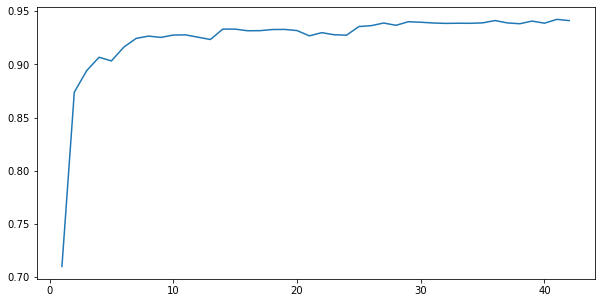

CPU times: total: 2d 10h 46min 46s
Wall time: 3h 48min 35s


In [889]:
%%time
best_features(train, test, features_importance)



# ###################################


# ###################################

# подгрузка данных для A/B

#### white box 

In [3]:
%%time
# данные с нормерами лидов и статусом от white box модели
leads_wb = pd.DataFrame()

with pymssql.connect(host='MSK1-ADB01', database='Analytic', charset="cp1251") as conn:
    leads_wb = pd.read_sql_query("SELECT * FROM dbo.TT_need with (nolock)", conn)

CPU times: total: 2.48 s
Wall time: 3.45 s


In [4]:
leads_wb['DATE_CREATE'] = pd.to_datetime(leads_wb['DATE_CREATE'])

In [5]:
#выделяю нужные даные из контрольной выборки для а/б теста
leads_wb_ab = \
(
    leads_wb[(leads_wb.sample_type == '2_контрольная выборка')
             &(leads_wb.DATE_CREATE >='2022-08-01')]
)

In [418]:
leads_wb_ab.shape

(98515, 6)

#### df_lead + leads_wb (берем их пересечение)

In [419]:
work_data_ab = test.merge(leads_wb_ab, left_on ='id_lead', right_on = 'lead_id', how ='inner')

In [420]:
work_data_ab.shape

(15826, 51)

In [421]:
work_data_ab = work_data_ab[work_data_ab['lead_status'].isin(['Сконвертирован', 'Перезвон', 'Перспектива', 'Спам'])]

# ----------------------------------
# data prep
# ----------------------------------

In [435]:
%%time
#заменяем таргет
work_data_ab['SPAM_flag_wb'] = \
(
    pd
    .Series(work_data_ab['lead_status_type'] =='1_спам, не ставили в CRM')
    .map({False: 0, True: 1})
)

CPU times: total: 15.6 ms
Wall time: 7.01 ms


In [434]:
work_data_ab['lead_status_type'].value_counts()

3_не спам                   14774
1_спам, не ставили в CRM     1052
Name: lead_status_type, dtype: int64

In [431]:
work_data_ab['SPAM_flag'].value_counts()

0    12837
1     2989
Name: SPAM_flag, dtype: int64

In [1]:
work_data_ab['SPAM_flag_wb'].value_counts()

NameError: name 'work_data_ab' is not defined

## ----------------------------------
## LAMA PREDICT
## ----------------------------------

In [425]:
%%time
ab_pred = automl.predict(work_data_ab[top_15_features + ['SPAM_flag']])

CPU times: total: 7.14 s
Wall time: 805 ms


In [436]:
#print('OOF ROC_AUC: {}'.format(roc_auc_score(train['SPAM_flag'].values, oof_pred.data[:, 0])))

#print('TEST ROC_AUC: {}'.format(roc_auc_score(test['SPAM_flag'].values,  test_pred.data[:, 0])))

print('BB ROC_AUC: {}'.format(roc_auc_score(work_data_ab['SPAM_flag'].values, ab_pred.data[:, 0])))
print('WB ROC_AUC: {}'.format(roc_auc_score(work_data_ab['SPAM_flag'].values, work_data_ab['SPAM_flag_wb'].values)))

BB ROC_AUC: 0.9610318851602875
WB ROC_AUC: 0.6557680543129331


In [437]:
work_data_ab['spam_proba'] = ab_pred.data[:,0]

# ---------------------------

In [443]:
bb_metrics = metrics_bb(work_data_ab, need_department)
bb_metrics.to_excel('metrics_bb_new.xlsx')

In [442]:
wb_metrics = metrics_wb(work_data_ab, need_department)
wb_metrics.to_excel('metrics_wb_new.xlsx')

# ##############################
# AUTOWOE

In [585]:
from autowoe import ReportDeco, AutoWoE

In [587]:
train[top_15_features].head()

,phone_check,sourceCode,title_check,Region_IP,flag_campaign,PHONE_digit_unique_share,Country_IP,email_domain,title_length,title_alpha_upper_share,flag_MERGE_LEAD,hour,title_alpha_unique_share,title_has_cyrillic_letter,PHONE_length
71551,1,1.493859,1,-0.387088,0,0.454545,-0.244787,-0.291608,-0.848664,0.250000,1,18,0.750000,1,-0.127599
71552,1,-0.263820,1,-0.506700,1,0.636364,-0.244787,-0.291608,-0.456309,0.166667,1,18,1.000000,1,-0.127599
71553,1,-0.507608,1,-0.381225,1,0.454545,-0.244787,-0.291608,-0.063954,0.125000,0,18,0.875000,1,-0.127599
71555,1,-0.380860,1,0.923364,1,0.727273,-0.244787,-0.072259,1.113111,0.133333,0,18,0.666667,0,-0.127599
71556,1,-0.523832,1,-0.440155,1,0.727273,-0.244787,-0.291608,0.916933,0.142857,1,18,0.857143,1,-0.127599


In [589]:
features_type =\
{
    'phone_check':'cat',
    'sourceCode':'real',
    'title_check':'cat',
    'Region_IP':'real',
    'flag_campaign':'cat',
    'PHONE_digit_unique_share':'real',
    'Country_IP':'real',
    'email_domain':'real',
    'title_length':'real',
    'title_alpha_upper_share':'real',
    'flag_MERGE_LEAD':'cat',
    'hour':'cat',
    'title_alpha_unique_share':'real',
    'title_has_cyrillic_letter':'cat',
    'PHONE_length':'real'    
}

In [591]:
auto_woe = AutoWoE(interpreted_model=True,
                     monotonic=False,
                    # попробовать поменять параметр, задать в цикле разные занчения
                     max_bin_count=7,
                     select_type=None,
                     pearson_th=0.9,
                     auc_th=.505,
                     vif_th=10.,
                     imp_th=0,
                     th_const=32,
                     force_single_split=True,
                     th_nan=0.01,
                     th_cat=0.005,
                     woe_diff_th=0.01,
                     min_bin_size=0.01,
                     min_bin_mults=(2, 4),
                     min_gains_to_split=(0.0, 0.5, 1.0),
                     auc_tol=1e-4,
                     cat_alpha=100,
                     cat_merge_to="to_woe_0",
                     nan_merge_to="to_woe_0",
                     oof_woe=True,
                     n_folds=6,
                     n_jobs=4,
                     l1_grid_size=20,
                     l1_exp_scale=6,
                     imp_type="feature_imp",
                     regularized_refit=False,
                     p_val=0.05,
                     debug=False,
                     verbose=0
        )

auto_woe = ReportDeco(auto_woe)

In [592]:
%%time
auto_woe.fit(train[top_15_features + ['SPAM_flag']], 
             target_name="SPAM_flag",
             features_type=features_type,
             group_kf=None,
             #max_bin_count=max_bin_count,
             #features_monotone_constraints=features_monotone_constraints,
             #validation=test
            )

CPU times: total: 7min 56s
Wall time: 7min 20s


In [593]:
%%time
woe_train_pred = auto_woe.predict_proba(train[top_15_features + ['SPAM_flag']])

CPU times: total: 1min 44s
Wall time: 1min 42s


0.936436334986563

In [594]:
%%time
woe_test_pred = auto_woe.predict_proba(test[top_15_features + ['SPAM_flag']])

CPU times: total: 1min 16s
Wall time: 1min 14s


In [595]:
%%time
woe_ab_pred = auto_woe.predict_proba(work_data_ab[top_15_features + ['SPAM_flag']])

CPU times: total: 15.1 s
Wall time: 13.7 s


In [597]:
display(roc_auc_score(train['SPAM_flag'], woe_train_pred),
roc_auc_score(test['SPAM_flag'], woe_test_pred),
roc_auc_score(work_data_ab['SPAM_flag'], woe_ab_pred))

0.936436334986563

0.9586247819483145

0.9016428360490687

In [598]:
%%time
report_params = {"automl_date_column": "2022-10-04",
                 "output_path": r"C:\Users\DDubai\Desktop\модель по спаму", # папка, куда сгенерится отчет и сложатся нужные файлы
                 "report_name": "Модель на спам",
                 "report_version_id": 1,
                 "city": "Москва",
                 "model_aim": "Оценка вероятности спам лида",
                 "model_name": "Модель на спам",
                 "zakazchik": "----------",
                 "high_level_department": "Аналитический центр",
                 "ds_name": "Duabi",
                 "target_descr": "вероятность спама",
                 "non_target_descr": "--"}

auto_woe.generate_report(report_params)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

CPU times: total: 20.1 s
Wall time: 20.1 s


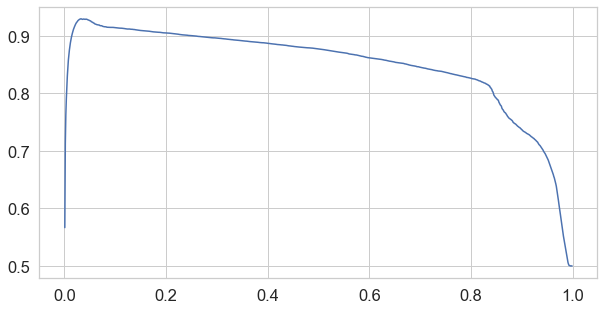

CPU times: total: 2min 7s
Wall time: 2min 7s


In [612]:
%%time
best_ridge(test, 0.001, 0.001)